# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [5]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [6]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

dataT  = torch.tensor( data[cols2zscore].values ).float()

# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
#data['boolQuality'][data['quality']>5] = 1

# note: use the following lines to avoid the warning message
#tmp = (data['quality']>qualThreshold ).astype(int)
#data['boolQuality'] = tmp

In [7]:
def getDataLoaders(qualThreshold):
   
   # create a new column for binarized (boolean) quality
   data['boolQuality'] = 0

   tmp = (data['quality']>qualThreshold ).astype(int)
   data['boolQuality'] = tmp

   # convert from pandas dataframe to tensor   
   labels = torch.tensor( data['boolQuality'].values ).float()
   labels = labels[:,None] # transform to matrix

   # use scikitlearn to split the data
   train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

   # then convert them into PyTorch Datasets (note: already converted to tensors)
   train_data = torch.utils.data.TensorDataset(train_data,train_labels)
   test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

   # finally, translate into dataloader objects
   batchsize    = 16
   train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
   test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

   return train_loader, test_loader


# Now for the DL part

In [8]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)   
  
  # forward pass
  def forward(self,x):    
    x = F.leaky_relu( self.input(x) )
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    return self.output(x)

# Train the model

In [9]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel(train_loader, test_loader):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [10]:
qualThresholds = [4.5, 5.5, 6.5]

trainByQual = np.zeros((numepochs,len(qualThresholds)))
testByQual  = np.zeros((numepochs,len(qualThresholds)))
lossByQual  = np.zeros((numepochs,len(qualThresholds)))

goodAcc = np.zeros((len(qualThresholds)))
badAcc = np.zeros((len(qualThresholds)))

trainLoader = []

for qi,qual in enumerate(qualThresholds):
  
  # get the data loaders
  trnloader, tstloader = getDataLoaders(qual)

  trainLoader.append(trnloader)

  # create a model and train it  
  winenet = ANNwine()
  trainByQual[:,qi],testByQual[:,qi],lossByQual[:,qi] = trainTheModel(trnloader, tstloader)

  X,y = next(iter(tstloader))
  yHat = winenet(X)

  itemAccuracy = ((yHat> 0) == y ).float()

  goodAcc[qi] = 100*torch.mean(itemAccuracy[y==1])

  badAcc[qi] = 100*torch.mean(itemAccuracy[y==0])

  


In [11]:
badAcc

array([25.        , 74.11764526, 94.2857132 ])

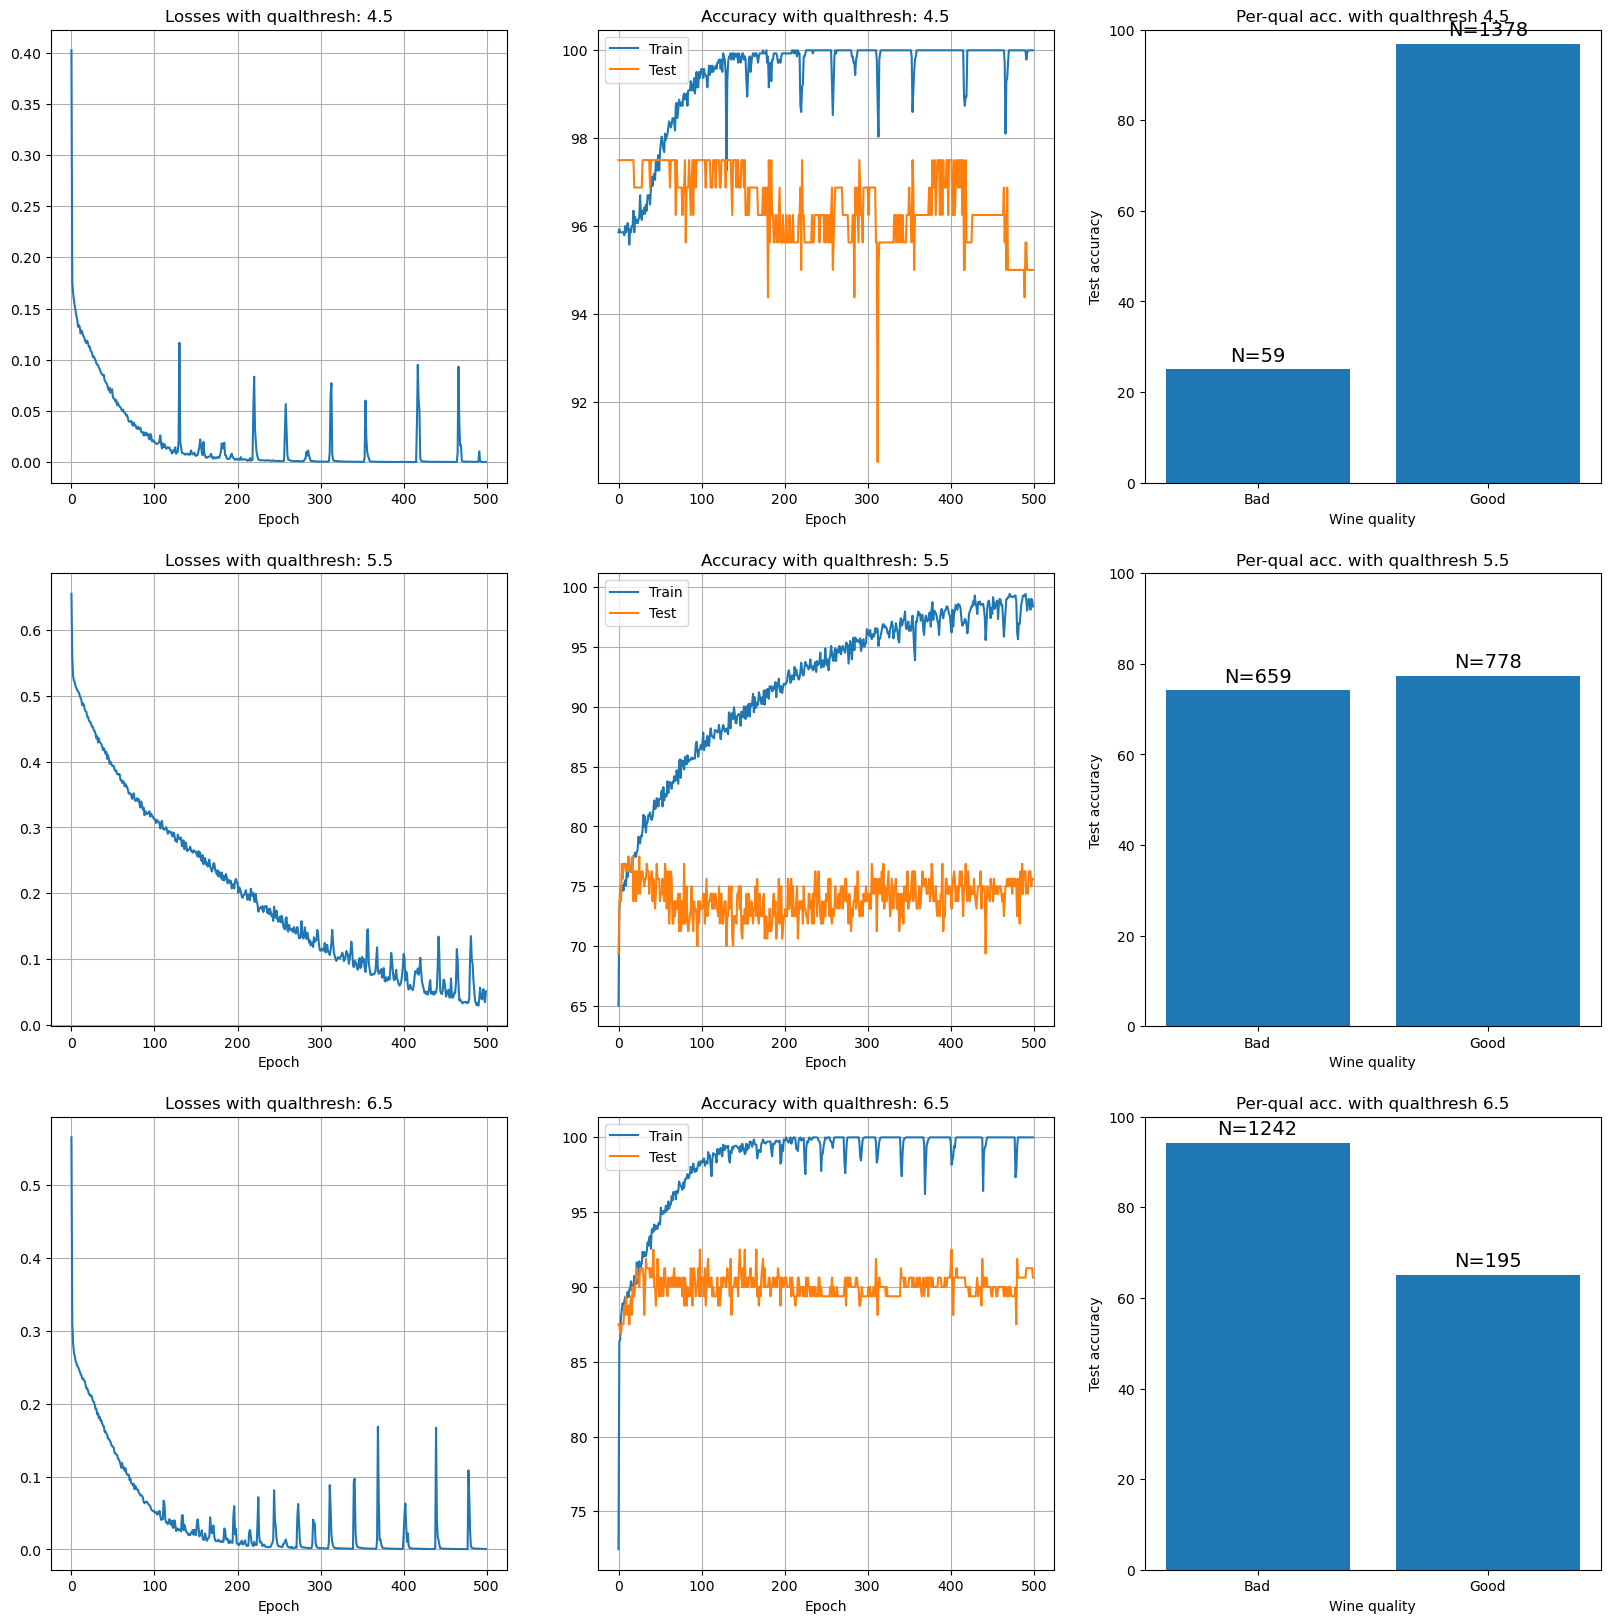

In [14]:
# plot some results
fig,ax = plt.subplots(3,3,figsize=(20,20))


for i, qual in enumerate(qualThresholds):
   ax[i,0].plot(lossByQual[:,i])
   ax[i,0].set_title(f'Losses with qualthresh: {qual:.1f}')
   ax[i,0].set_xlabel('Epoch')
   ax[i,0].grid()
   ax[i,1].plot(trainByQual[:,i], label='Train')
   ax[i,1].plot(testByQual[:,i], label='Test')
   ax[i,1].set_title(f'Accuracy with qualthresh: {qual:.1f}')
   ax[i,1].set_xlabel('Epoch')
   ax[i,1].legend()
   ax[i,1].grid()
   

   # plot the per-quality accuracy
   bh = ax[i,2].bar(['Bad','Good'],[badAcc[i],goodAcc[i]])
   ax[i,2].set_ylim([0,100])
   ax[i,2].set_xlabel('Wine quality')
   ax[i,2].set_ylabel('Test accuracy')
   ax[i,2].set_title(f'Per-qual acc. with qualthresh {qual:.1f}')

   # print the counts on top of each bar
   for ibh,r in enumerate(bh):
     N = torch.sum(trainLoader[i].dataset.tensors[1]==ibh).item()
     ax[i,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)

  


plt.show()

# Additional explorations

In [13]:
# This was a pretty straightforward codeChallenge, so there isn't much to expand. Feel free to try exploring the 
# standard DL metaparameters, including learning rate, number of training epochs, and batch size.
# 
# It's also interesting the include other activation functions into the comparison. The following site lists the functions.
#   https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
